In [5]:
### ARCHITECTURE SEARCH : averaging psychophysical results across architectures ###
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f:
        valid_metrics_dict = json.load(f)
    if metric_key not in valid_metrics_dict.keys():
        # If metric_key does not exist in validation_metrics_dict, look for a similarly named key
        for available_key in valid_metrics_dict.keys():
            if all([mkp in available_key for mkp in metric_key.split(':')]):
                metric_key = available_key
                break
    metric_values = valid_metrics_dict[metric_key]
    if maximize:
        best_metric_value = np.max(metric_values)
    else:
        best_metric_value = np.min(metric_values)
    return best_metric_value

# ### Specify scope of all models to compare (regex must grab all model output directories)
# # regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/'
# # regex_model_dir = '/nobackup/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/'

# # regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalLPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# # regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalBPv00_AN_BW10eN1_IHC3000Hz_classification*/'
# # regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase01_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/'

# tmp_list_model_dir = sorted(glob.glob(regex_model_dir))


# Specify list of models to load (each entry can glob multiple models to average across)
list_regex_model_dir = [
#     '/saved_models/arch_search_v02_topN/f0_label_024/arch_0???/',
#     '/saved_models/arch_search_v02_topN/f0_label_048/arch_0???/',
#     '/saved_models/arch_search_v02_topN/f0_label_096/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/f0_label_384/arch_0???/',

#     'human',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0083/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0154/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0190/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0191/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0286/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0288/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0302/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0335/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0338/',
#     '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0346/',

    '/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_0???/',
    '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'EVAL_SOFTMAX_flat_exc_mean'),
    
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species004_spont070_BWlinear_IHC3000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalLPv01/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalHPv00/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08spch_noise_TLAS_snr_neg10pos10/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_pos10pos30/arch_0???/',
#     '/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_posInf/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0083/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0154/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0190/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0286/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0288/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0335/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0338/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0346/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/',
    
#     'human',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',
    
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed0/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed1/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed2/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed3/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed4/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed5/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed6/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed7/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed8/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed9/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/',

#     'human',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont1eN1_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',

#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed0/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed1/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed2/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed3/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed4/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed5/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed6/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed7/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed8/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed9/',
#     '/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/',

#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_posInf_AN_BW10eN1_IHC3000Hz_classification*/',

#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0050Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0250Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC1000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC6000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC9000Hz_classification*/',

#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW05eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW20eN1_IHC3000Hz_classification*/',
    
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'EVAL_SOFTMAX_flat_exc_mean'),
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_flat_exc_classification*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/',
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/', 'EVAL_SOFTMAX_flat_exc_mean'),
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order_flat_exc/arch_*/',
    
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalLPv01_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08spch_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08inst_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PNDv08matched12_TLASmatched12_snr_neg10pos10_phase0_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PNDv08negated12_TLASmatched12_snr_neg10pos10_phase0_AN_BW10eN1_IHC3000Hz_classification*/',

#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_spont1eN1_BW10eN1_IHC3000Hz_classification*/',

#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_*/',

#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/',
#     '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_*/',

#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification1/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification2/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification3/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification4/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification5/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification6/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification7/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification8/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification9/',

#     '/saved_models/models_sr20000/arch_0302/f0_label_024_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/f0_label_048_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
# #     '/saved_models/models_sr20000/arch_0302/f0_label_096_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_sr20000/arch_0302/f0_label_384_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
    
#     '/saved_models/models_sr20000/arch_0302/f0_label_024_PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/',
#     '/saved_models/models_sr20000/arch_0302/f0_label_048_PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/',
#     '/saved_models/models_sr20000/arch_0302/f0_label_384_PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/',

#     'human',
#     '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/',
#     '/saved_models/models_metamer/arch_0302_PND_v08_TLAS_snr_neg10pos10_AN_RSB_noise0000_classification0/',
]

# Specify basename for validation metrics
basename_valid_metrics = 'validation_metrics.json'

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_transposedtones_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_freqshifted_v01_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_mistunedharm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_altphase_v01_bestckpt_results_dict.json',
}
# for k in experiment_to_basename_map.keys():
#     experiment_to_basename_map[k] = experiment_to_basename_map[k].replace('EVAL_SOFTMAX', 'EVAL_SOFTMAX_flat_exc_mean')

# Specify human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

# Specify list of experiments to load
experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]

# Compile list of lists of model psychophysical data to plot grid of results (models-by-experiments) 
list_list_model_dir = []
list_list_valid_metric = []
list_dict_results_dicts = []
# For each entry in list_regex_model_dir, grab all of the models that are globbed by the regex
for regex_model_dir in list_regex_model_dir:
    prefix = None
    if isinstance(regex_model_dir, tuple):
        (regex_model_dir, prefix) = regex_model_dir
    list_model_dir = []
    list_valid_metric = []
    dict_results_dicts = {ek: [] for ek in experiment_keys}
    if 'HUMAN' in regex_model_dir.upper():
        list_model_dir = 'HUMAN'
        list_valid_metric = None
        dict_results_dicts = experiment_to_human_results_map
    else:
        for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
            fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
            fn_result_dict = {
                ek: os.path.join(model_dir, experiment_to_basename_map[ek]) for ek in experiment_keys
            }
            if prefix is not None:
                for k in fn_result_dict.keys():
                    fn_result_dict[k] = fn_result_dict[k].replace('EVAL_SOFTMAX', prefix)
                    print(fn_result_dict[k])
            include_model_flag = True
            for ek in experiment_keys:
                if not os.path.exists(fn_result_dict[ek]): include_model_flag = False
            if include_model_flag:
                list_valid_metric.append(calc_best_metric(fn_valid_metric))
                list_model_dir.append(model_dir)
                # Load results_dict for each model
                for ek, results_dict_fn in fn_result_dict.items():
                    with open(results_dict_fn) as f:
                        dict_results_dicts[ek].append(json.load(f))
    
    # Add lists of model results to the master list
    list_list_valid_metric.append(list_valid_metric)
    list_list_model_dir.append(list_model_dir)
    list_dict_results_dicts.append(dict_results_dicts)
    print(regex_model_dir, len(list_model_dir), list_valid_metric)


/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/ 10 [0.10164345800876617, 0.09105217456817627, 0.11136086285114288, 0.09014496207237244, 0.160112202167511, 0.09903135150671005, 0.12266172468662262, 0.12026868760585785, 0.13098378479480743, 0.10848445445299149]
/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/ 10 [0.03248104453086853, 0.07755590975284576, 0.09880991280078888, 0.07105541229248047, 0.10143867880105972, 0.05387077108025551, 0.09715025871992111, 0.04599398002028465, 0.018172813579440117, 0.07643915712833405]
/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0???/ 10 [0.1028745025396347, 0.11636600643396378, 0.14973759651184082, 0.11929242312908173, 0.13501980900764465, 0.08761143684387207, 0.15862874686717987, 0.11564690619707108, 0.08062280714511871, 0.12401182949542999]
/saved_models/arch_searc

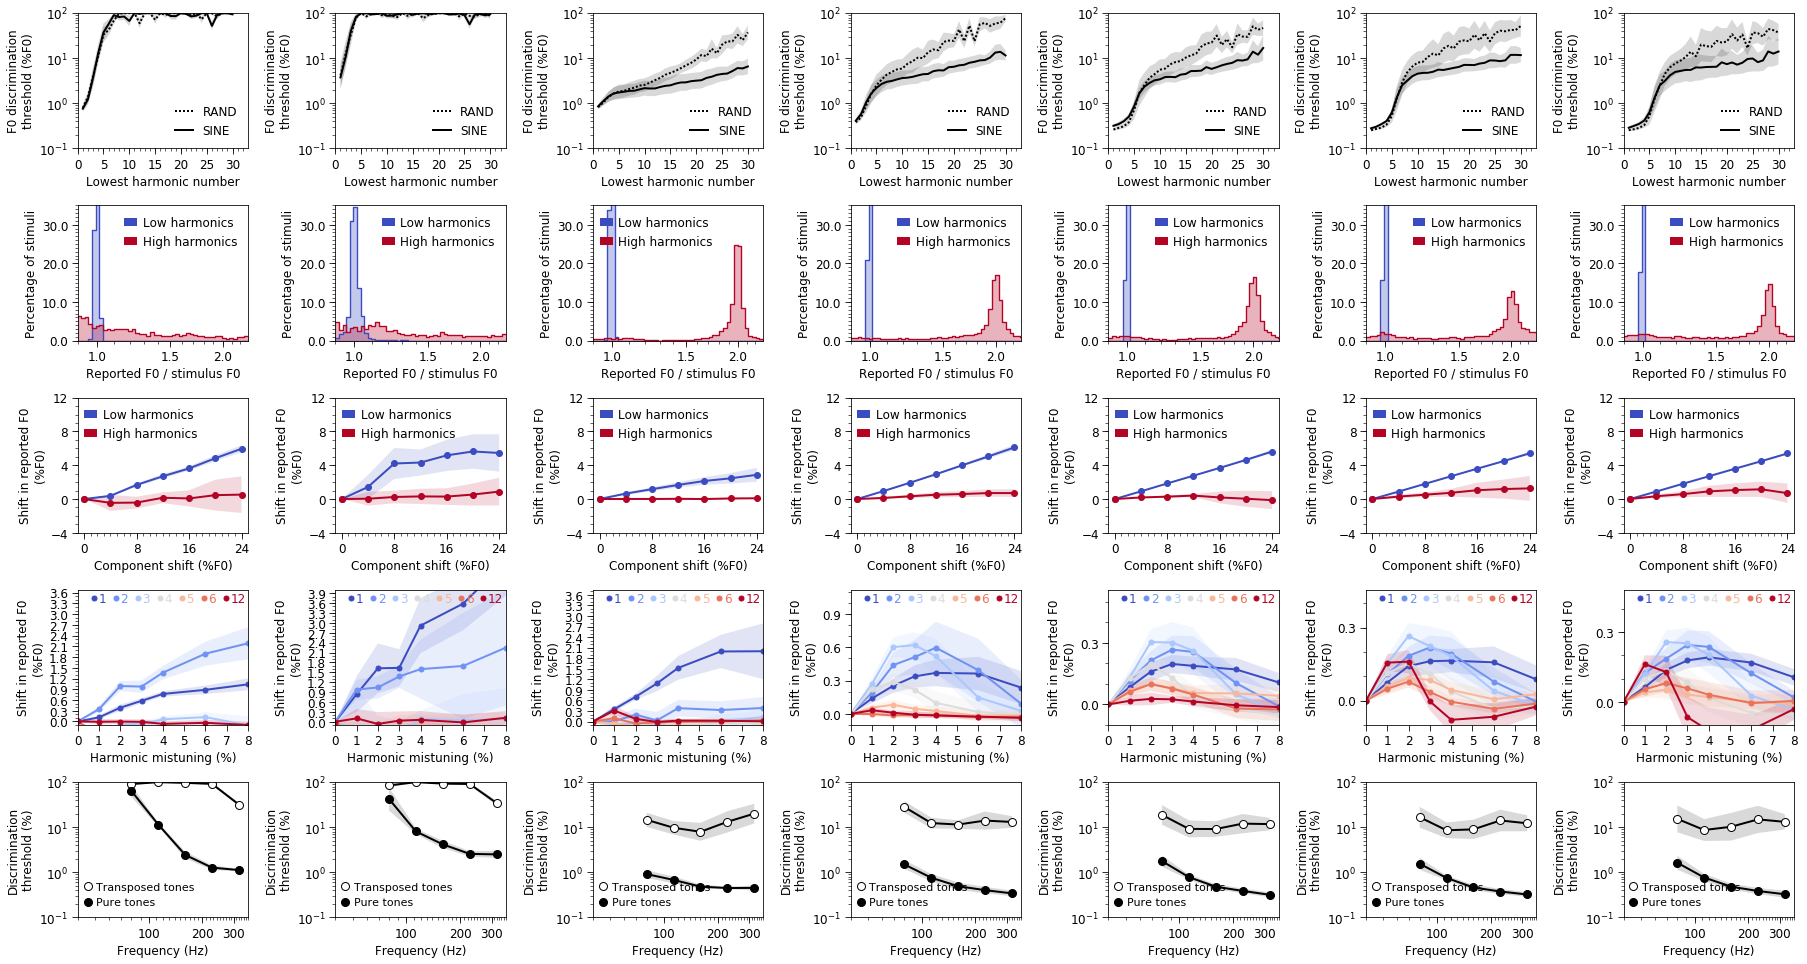

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/psychophysics_all_manipulation_IHClowpass.pdf


In [6]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
#     'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_bar_graph,
#     'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_graph,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
#     'altphasecomplexes': util_figures_psychophysics.make_altphase_line_plot,
}

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]

NROWS = len(experiment_keys)
NCOLS = len(list_dict_results_dicts)
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, (dict_results_dicts, list_model_dir) in enumerate(zip(list_dict_results_dicts, list_list_model_dir)):
    for r_idx, key in enumerate(experiment_keys):
        results_dict_input = dict_results_dicts[key]
        plot_fcn = experiment_to_plot_fcn_map[key]
        # Specify kwargs for all psychophysics subplots
        kwargs = {
            'include_yerr': True,
        }
        # Modify kwargs for special cases
        if (isinstance(list_model_dir, str)) and (list_model_dir == 'HUMAN'):
            kwargs['include_yerr'] = False
        plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)

plt.tight_layout()
plt.show()

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_all_HUMANS_and_MODELS.pdf')
# save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_sound_statistics_SNR.pdf')
# save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_sound_statistics_training_stimuli.pdf')
save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_IHClowpass.pdf')
# save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_cochFilterBWs.pdf')
# save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_spont_rate.pdf')
# save_fn = os.path.join(save_dir, 'psychophysics_all_manipulation_flat_exc_mean_test.pdf')
fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
print(save_fn)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0)


In [14]:
# for r in range(ax.shape[0]):
#     for c in range(ax.shape[1]):
#         bbox_inches = ax[r, c].get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
#         save_fn = os.path.join(save_dir, 'panel_{}{}.pdf'.format(r, c))
#         fig.savefig(save_fn, bbox_inches=bbox_inches, pad_inches=0)


In [1]:
NROWS = len(experiment_keys)
NCOLS = 1
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = np.array(ax).reshape([-1])

experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

for ax_idx, key in enumerate(experiment_keys):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {
        'include_yerr': True,
    }
    plot_fcn(ax[ax_idx], results_dicts[key], **kwargs)
#     plot_fcn(ax[ax_idx], experiment_to_human_results_map[key], **kwargs)

plt.tight_layout()
plt.show()

# model_name = regex_model_dir
# model_name = model_name.replace('/saved_models/models_sr20000/arch_0302/', '')
# model_name = model_name.replace('*/', '')
# # model_name = 'arch_search_v01_rank_{:03}to{:03}'.format(idxxx, idxxx+40)
# # model_name = 'HUMANS'
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/'
# save_fn = os.path.join(save_dir, 'psychophysics_all_{}.pdf')
# save_fn = save_fn.format(model_name)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


NameError: name 'experiment_keys' is not defined

In [ ]:
experiment_keys_tmp = ['mistunedharmonics']

NROWS = len(experiment_keys_tmp)
NCOLS = 1
figsize = (2*4*NCOLS*0.9, 2*3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = np.array(ax).reshape([-1])

experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

for ax_idx, key in enumerate(experiment_keys_tmp):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {
        'include_yerr': True,
    }
    plot_fcn(ax[ax_idx], results_dicts[key], **kwargs)
#     plot_fcn(ax[ax_idx], experiment_to_human_results_map[key], **kwargs)

plt.tight_layout()
plt.show()



In [ ]:
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
_ = util_figures_psychophysics.make_altphase_histogram_plot(ax, experiment_to_human_results_map['altphasecomplexes'])
plt.show()



# fig, ax = util_figures_psychophysics.make_altphase_histograms(top_model_results_dicts['altphasecomplexes'])
# plt.show()


In [ ]:
### GENERIC PARAMETERS
figsize=(4,3)
poster_plot_kwargs = {
    'fontsize_labels': 16,
    'fontsize_legend': 14,
    'fontsize_ticks': 14,
    'include_yerr': True,
    'kwargs_bootstrap': {
        'bootstrap_repeats': 1000,
        'metric_function': 'median',
    },
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}


In [ ]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['xlimits'] = [0, 33]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['bernox2005'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


# PLOT HUMAN
sine_plot_kwargs={'marker': '.', 'ms':12}
rand_plot_kwargs={'marker': '.', 'ms':12}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs,
         sine_plot_kwargs=sine_plot_kwargs,
         rand_plot_kwargs=rand_plot_kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_bernox_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### transposed tones discrimination thresholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_TT_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_transposedtones()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 11
kwargs['xlimits'] = [40, 360]
kwargs['ylimits'] = [0.15, 50]
kwargs['threshold_cap'] = 50

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['transposedtones'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_transposedtones_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_transposedtones_threshold_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### frequency shifted complexes

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_freqshiftedcomplexes_plot
human_rd = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['restrict_conditions'] = ['5', '11', '16']
# kwargs['cmap_name'] = ['r', 'b', 'k']#'Dark2'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['freqshiftedcomplexes'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_freqshift_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_freqshift_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### mistuned harmonics bar graph

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_mistuned_harmonics_bar_graph
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['cmap_name'] = 'tab10'

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_mistunedharm_bar_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
kwargs_human = copy.deepcopy(kwargs)
kwargs_human['include_yerr'] = False
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs_human, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_mistunedharm_bar_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### mistuned harmonics line plot

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_mistuned_harmonics_line_plot
human_rd = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

kwargs = copy.deepcopy(poster_plot_kwargs)
# kwargs['cmap_name'] = 'Accent'
kwargs['ylimits'] = [-0.1, 0.4]
kwargs['yticks'] = 0.2

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['mistunedharmonics'], **kwargs, use_relative_shift=True)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_mistunedharm_line200Hz_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


plt.show()

In [ ]:
### alt phase line plot

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_altphase_line_plot
human_rd = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

kwargs = copy.deepcopy(poster_plot_kwargs)
kwargs['fontsize_legend'] = 13

# PLOT MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, results_dicts['altphasecomplexes'], **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_altphase_line_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

# PLOT HUMAN
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
plot_fcn(ax, human_rd, **kwargs)
plt.tight_layout()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
# save_fn = os.path.join(save_dir, 'human_altphase_line_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')

plt.show()

In [ ]:
### altphase histograms

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

# PLOT MODEL
fig, ax = util_figures_psychophysics.make_altphase_histograms(results_dicts['altphasecomplexes'],
                                                              bin_step=0.01,
                                                              figsize=(8,5),
                                                              fontsize_labels=18,
                                                              fontsize_legend=16,
                                                              fontsize_ticks=14,
                                                              xticks=[1.0, 1.5, 2.0],
                                                              xlimits=[0.9, 2.3],
                                                              yticks=5,
                                                              ylimits=[0, 25],
                                                              condition_plot_labels={})

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_11_07_manipulating_bez2018model/'
# save_fn = os.path.join(save_dir, 'arch0628_spike_counts_npc20_altphase_histogram_plot.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


In [11]:
import sys
import os
import json
import numpy as np
import glob
import copy
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_figures_psychophysics
importlib.reload(util_figures_psychophysics)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures


### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
# results_dict_basename = 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json'
results_dict_basename = 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json'

### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0302_seed*/', '2x narrower BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0302_seed*/', 'Human filter BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0302_seed*/', '2x broader BWs'),
    
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', '2x narrower BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', 'Human filter BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', '2x broader BWs'),
    
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'Natural'),
#     ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalLPv01/arch_0???/', 'Lowpass'),
#     ('/saved_models/arch_search_v02_topN/PND_v08_noise_TLAS_snr_neg10pos10_filter_signalHPv00/arch_0???/', 'Highpass'),
#     ('/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSmatched12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/', 'Matched'),
#     ('/saved_models/arch_search_v02_topN/PND_mfcc_PNDv08PYSnegated12_TLASmatched12_snr_neg10pos10_phase3/arch_0???/', 'Anti-matched'),
#     ('/saved_models/arch_search_v02_topN/PND_v08spch_noise_TLAS_snr_neg10pos10/arch_0???/', 'Speech only'),
#     ('/saved_models/arch_search_v02_topN/PND_v08inst_noise_TLAS_snr_neg10pos10/arch_0???/', 'Music only'),
    
#     ('/saved_models/arch_search_v02_topN/f0_label_024/arch_0???/', '1/2 st'),
#     ('/saved_models/arch_search_v02_topN/f0_label_048/arch_0???/', '1/4 st'),
#     ('/saved_models/arch_search_v02_topN/f0_label_096/arch_0???/', '1/8 st'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', '1/16 st'),
#     ('/saved_models/arch_search_v02_topN/f0_label_384/arch_0???/', '1/32 st'),

#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/', '2x narrower BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'Human filter BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/', '2x broader BWs'),

    ('/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz**'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz'),
    ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0???/', '250Hz'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_0???/', '1000Hz'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', '3000Hz'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_0???/', '6000Hz'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_0???/', '9000Hz'),
]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


Loaded results from 60 files (EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json)
3000Hz 10
50Hz** 10
6000Hz 10
9000Hz 10
250Hz 10
1000Hz 10


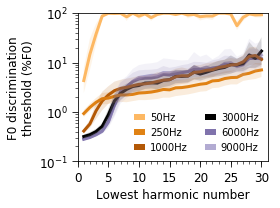

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/psychophysics_bernoxSinePhase_manipulation_IHClowpass.pdf


In [7]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()


legend_loc = 'lower right'
add_lines = False
save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
if 'natural' in model_keys[0].lower():
    color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR FILTERING SOUNDS
    color_list = [color_list[idx] for idx in [0, 2, 4]]
    legend_loc = 'upper right'
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_natural.pdf')
elif 'matched' in model_keys[0].lower():
    color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR SYNTHETIC TONES
    color_list = [color_list[idx] for idx in [0, 4]]
    legend_loc = 'upper right'
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_synthetic.pdf')
elif 'only' in model_keys[0].lower():
    color_list = util_figures.get_color_list(8, cmap_name='Accent') # CMAP FOR SPEECH VS MUSIC
    color_list = [color_list[idx] for idx in [4,5]]
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_speech_vs_music.pdf')
elif 'BW' in model_keys[0].upper():
    color_list = ['#5ab4ac', 'k', '#a6611a'] # CMAP FOR COCH FILTER BW
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_cochFilterBWs.pdf')
elif 'hz' in model_keys[0].lower():
    color_list = ['#fdb863', '#e08214', '#b35806', 'k', '#8073ac', '#b2abd2'] #  CMAP FOR IHC LOWPASS
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_IHClowpass.pdf')
elif '/' in model_keys[0]:
    color_list = ['#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026'] # CMAP for F0 bin width
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_f0_bin_width.pdf')
else:
    raise ValueError("Failed to automatically specify color_list and save_fn!!!")


kwargs = {
    'xlimits': [0,31],
    'include_yerr': True,
    'legend_on': True,
    'restrict_conditions': [0],
}
kwargs['kwargs_legend'] = {
    'loc': legend_loc,
    'ncol': 2,
    'frameon': False,
    'framealpha': 1.0,
    'facecolor': 'w',
    'edgecolor': 'k',
    'handlelength': 0.5,
    'markerscale': 0.0,
    'fontsize': 10.0,
    'borderpad': 0.6,
    'borderaxespad': 0.3,
}
if len(model_keys) < 4:
    kwargs['kwargs_legend']['ncol'] = 1
    kwargs['kwargs_legend']['frameon'] = True

NROWS = 1
NCOLS = 1
# figsize = (4*NCOLS*.9, 3*NROWS*.9)
figsize = (4, 3)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)


### PLOT MODEL ###
zorder = 0
for cidx, key in enumerate(model_keys):
    kwargs['sine_plot_kwargs'] = {
        'label': key,
        'color': color_list[cidx],
        'lw': 3,
        'zorder': zorder,
    }
    kwargs['rand_plot_kwargs'] = {
        'label': None,
        'color': color_list[cidx],
        'lw': 3,
        'zorder': zorder,
    }
#     for rd in results_dicts[key]:
#         plot_fcn(ax, rd, **kwargs)

    rd_itr0 = plot_fcn(ax, results_dicts[key], **kwargs)
    zorder -= 1

import matplotlib
leg = [c for c in ax.get_children() if isinstance(c, matplotlib.legend.Legend)]
if len(leg) == 1:
    for legobj in leg[0].legendHandles:
        legobj.set_linewidth(6.0)

plt.tight_layout()
plt.show()

# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)


[3 2 2 2 4 1 2 3 2 2] 2.3
[19  1  1  2  2  2  2  1 19  2] 5.1
[5 4 4 5 3 4 2 4 3 4] 3.8
[6 5 5 7 6 6 5 6 5 6] 5.7
[7 6 5 6 7 7 6 6 6 8] 6.4
[7 5 6 7 7 8 5 6 6 9] 6.6


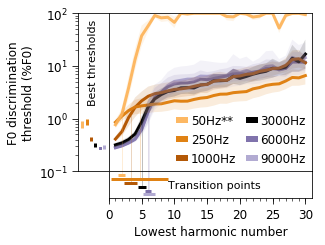

In [12]:
### bernox2005 discrimination threholds

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()


save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
if 'natural' in model_keys[0].lower():
    color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR FILTERING SOUNDS
    color_list = [color_list[idx] for idx in [0, 2, 4]]
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_natural.pdf')
elif 'matched' in model_keys[0].lower():
    color_list = util_figures.get_color_list(6, cmap_name='gist_heat') # CMAP FOR SYNTHETIC TONES
    color_list = [color_list[idx] for idx in [0, 4]]
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_synthetic.pdf')
elif 'only' in model_keys[0].lower():
    color_list = util_figures.get_color_list(8, cmap_name='Accent') # CMAP FOR SPEECH VS MUSIC
    color_list = [color_list[idx] for idx in [4,5]]
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_sound_statistics_speech_vs_music.pdf')
elif 'BW' in model_keys[0].upper():
    color_list = ['#5ab4ac', 'k', '#a6611a'] # CMAP FOR COCH FILTER BW
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_cochFilterBWs.pdf')
elif 'hz' in model_keys[0].lower():
    color_list = ['#fdb863', '#e08214', '#b35806', 'k', '#8073ac', '#b2abd2'] #  CMAP FOR IHC LOWPASS
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_IHClowpass.pdf')
elif '/' in model_keys[0]:
    color_list = ['#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026'] # CMAP for F0 bin width
    save_fn = os.path.join(save_dir, 'psychophysics_bernoxSinePhase_manipulation_f0_bin_width.pdf')
else:
    raise ValueError("Failed to automatically specify color_list and save_fn!!!")



def get_transition_point(results_dict, phase_mode=0, transition_f0dl=1.0):
    '''
    '''
    list_phase_mode = np.array(results_dict['phase_mode'])
    list_low_harm = np.array(results_dict['low_harm'])[list_phase_mode == phase_mode]
    list_f0dl = np.array(results_dict['f0dl'])[list_phase_mode == phase_mode]
    return list_low_harm[list_f0dl > transition_f0dl][0]



kwargs = {
    'xlimits': [0,31],
    'include_yerr': True,
    'legend_on': True,
    'restrict_conditions': [0],
    'kwargs_legend': {
        'ncol': 2,
        'handlelength': 0.5,
        'borderpad': 0,
        'columnspacing': 1,
        'loc': 'lower right',
        'handletextpad': 0.5,
    },
#     'kwargs_bootstrap':{'bootstrap_repeats': 1000, 'metric_function': 'median'},
}
if len(model_keys) < 4:
    kwargs['kwargs_legend']['ncol'] = 1

NROWS = 2
NCOLS = 2
wratio = 6.5
hratio = 6.5 * 3.6/4
figsize = (4 * (wratio + 1) / wratio, 3 * (hratio + 1) / hratio)
gridspec_kw = {
    'width_ratios': [1, wratio],
    'height_ratios': [hratio, 1],
    'wspace': 0.0,
    'hspace': 0.0,
}
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw, sharex='col', sharey='row')


### PLOT MODEL ###
zorder = 0
for itr0, key in enumerate(model_keys):
    kwargs['sine_plot_kwargs'] = {
        'label': key,
        'color': color_list[itr0],
        'lw': 3,
        'zorder': zorder,
    }
    kwargs['rand_plot_kwargs'] = {
        'label': None,
        'color': color_list[itr0],
        'lw': 3,
        'zorder': zorder,
    }
    rd_itr0 = plot_fcn(ax_arr[0, 1], results_dicts[key], **kwargs)
    

    list_transition = np.array([get_transition_point(rd) for rd in results_dicts[key]])
    print(list_transition, list_transition.mean())
    transition_mean, transition_err = util_figures_psychophysics.bootstrap(list_transition)
    threshold_mask = np.logical_and(np.array(rd_itr0['phase_mode']) == 0,
                                    np.array(rd_itr0['low_harm']) == 1)
    log10_f0dl = rd_itr0['log10_f0dl'][threshold_mask][0]
    log10_f0dl_err = rd_itr0['log10_f0dl_err'][threshold_mask][0]
    
    line_plot_kwargs = {
        'lw': 0.50,
        'ls': '--',
        'dashes': (2, 2),
        'color': color_list[itr0],
        'zorder': zorder,
    }
    
#     ax_arr[0, 1].plot([0, 1],
#                       [np.power(10.0, log10_f0dl), np.power(10.0, log10_f0dl)],
#                       **line_plot_kwargs)
    line_ymin = 1e-1
    line_ymax = np.power(10.0, np.interp(transition_mean, rd_itr0['low_harm'], rd_itr0['log10_f0dl']))
    ax_arr[0, 1].plot([transition_mean, transition_mean],
                      [line_ymin, line_ymax],
                      **line_plot_kwargs)
    errorbar_kwargs = {
        'fmt': 's',
        'color': color_list[itr0],
        'ms': 2,
        'ecolor': color_list[itr0],
        'elinewidth': 3,
        'capsize': 0,
        'capthick': 0,
    }
    yerr = np.array([
        np.power(10.0, log10_f0dl) - np.power(10.0, log10_f0dl-2*log10_f0dl_err),
        np.power(10.0, log10_f0dl+2*log10_f0dl_err) - np.power(10.0, log10_f0dl)
    ]).reshape([2, -1])
    ax_arr[0, 0].errorbar(itr0, np.power(10.0, log10_f0dl), xerr=None, yerr=yerr, **errorbar_kwargs)
    ax_arr[1, 1].errorbar(transition_mean, len(model_keys)-itr0-1, xerr=2*transition_err, yerr=None, **errorbar_kwargs)
    
    
#     ax_arr[0, 0].plot([itr0, 100],
#                       [np.power(10.0, log10_f0dl), np.power(10.0, log10_f0dl)],
#                       **line_plot_kwargs)
    ax_arr[1, 1].plot([transition_mean, transition_mean],
                      [len(model_keys)-itr0-1, 100],
                      **line_plot_kwargs)
    zorder -= 1
    

import matplotlib
leg = [c for c in ax_arr[0, 1].get_children() if isinstance(c, matplotlib.legend.Legend)]
if len(leg) == 1:
    for legobj in leg[0].legendHandles:
        legobj.set_linewidth(6.0)

ax_arr[0, 1].set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
ax_arr[0, 1].tick_params(which='both', length=0)
fontsize_labels=12
fontsize_ticks=12
xlimits=[0, 31]
ylimits=[1e-1, 1e2]

util_figures.format_axes(ax_arr[0, 0],
                         str_xlabel=None,
                         str_ylabel='F0 discrimination\nthreshold (%F0)',
                         fontsize_labels=fontsize_labels,
                         fontsize_ticks=fontsize_ticks,
                         fontweight_labels=None,
                         xscale='linear',
                         yscale='log',
                         xlimits=[-1, itr0+1],
                         ylimits=ylimits,
                         xticks=[],
                         yticks=None,
                         xticks_minor=[],
                         yticks_minor=None,
                         xticklabels=[],
                         yticklabels=None,
                         spines_to_hide=[],
                         major_tick_params_kwargs_update={},
                         minor_tick_params_kwargs_update={})
util_figures.format_axes(ax_arr[1, 1],
                         str_xlabel='Lowest harmonic number',
                         str_ylabel=None,
                         fontsize_labels=fontsize_labels,
                         fontsize_ticks=fontsize_ticks,
                         fontweight_labels=None,
                         xscale='linear',
                         yscale='linear',
                         xlimits=xlimits,
                         ylimits=[-1, itr0+1],
                         xticks=np.arange(xlimits[0], xlimits[1], 5),
                         yticks=[],
                         xticks_minor=np.arange(xlimits[0], xlimits[1], 1),
                         yticks_minor=None,
                         xticklabels=None,
                         yticklabels=None,
                         spines_to_hide=[],
                         major_tick_params_kwargs_update={},
                         minor_tick_params_kwargs_update={})

ax_arr[0, 0].text(np.mean([-1, itr0+1]), 1.8, 'Best thresholds', {'ha': 'center', 'va': 'bottom'}, rotation=90, fontsize=11)
ax_arr[1, 1].text(9, np.mean([-1, itr0+1]), 'Transition points', {'ha': 'left', 'va': 'center'}, rotation=0, fontsize=11)

ax_arr[1, 0].axis('off')

plt.tight_layout()
plt.show()

# print(save_fn)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)

# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics
importlib.reload(util_human_model_comparison)
importlib.reload(util_figures_psychophysics)

# human_hist_results_dict = util_human_model_comparison.extract_data_from_alt_phase_histogram_ps_file()
human_hist_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()

fig, ax = util_figures_psychophysics.make_altphase_histograms(human_hist_results_dict)
plt.show()


In [ ]:
### ARCHITECTURE SEARCH : averaging psychophysical results across architectures ###
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics
import util_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'
# regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/'

tmp_list_model_dir = sorted(glob.glob(regex_model_dir))


basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
#     'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'bernox2006_TEN10dB': 'EVAL_SOFTMAX_bernox2006_TENlevel10dB_harmlevel20dBSPL_bestckpt_results_dict.json',
    'bernox2006_TEN40dB': 'EVAL_SOFTMAX_bernox2006_TENlevel40dB_harmlevel50dBSPL_bestckpt_results_dict.json',
    'bernox2006_TEN65dB': 'EVAL_SOFTMAX_bernox2006_TENlevel65dB_harmlevel75dBSPL_bestckpt_results_dict.json',
#     'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json',
#     'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
#     'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v01_bestckpt_results_dict.json',
#     'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
}
# for key in experiment_to_basename_map.keys():
#     experiment_to_basename_map[key] = experiment_to_basename_map[key].replace('EVAL_SOFTMAX_', 'EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_ANMODEL_')

experiment_keys = [
#     'bernox2005',
    'bernox2006_TEN10dB',
    'bernox2006_TEN40dB',
    'bernox2006_TEN65dB',
#     'altphasecomplexes',
#     'freqshiftedcomplexes',
#     'mistunedharmonics',
#     'transposedtones',
]
list_valid_metric = []
list_model_dir = []
disp_step = 100

for idx, model_dir in enumerate(tmp_list_model_dir):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)

print('Number of included networks:', len(list_valid_metric))


In [ ]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

top_model_dirs = list_model_dir

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'bernox2006_TEN10dB': util_figures_psychophysics.make_bernox_threshold_plot,
    'bernox2006_TEN40dB': util_figures_psychophysics.make_bernox_threshold_plot,
    'bernox2006_TEN65dB': util_figures_psychophysics.make_bernox_threshold_plot,
#     'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
#     'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
# #     'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_bar_graph,
# #     'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_graph,
#     'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
#     'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
# #     'altphasecomplexes': util_figures_psychophysics.make_altphase_line_plot,
}

top_model_results_dicts = {key: [] for key in experiment_keys}
for key in experiment_keys:
    for model_dir in top_model_dirs:
        results_dict_fn = os.path.join(model_dir, experiment_to_basename_map[key])
        with open(results_dict_fn) as f:
            top_model_results_dicts[key].append(json.load(f))

results_dicts = top_model_results_dicts


In [ ]:
NROWS = 1
NCOLS = 1
figsize = (4*NCOLS*1.9, 3*NROWS*1.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = np.array(ax).reshape([-1])

color_list = util_figures.get_color_list(10, cmap_name='tab10')
for ax_idx, key in enumerate(experiment_keys):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {
        'include_yerr': True,
        'sine_plot_kwargs': {'label': key, 'color': color_list[ax_idx], 'lw': 4},
        'rand_plot_kwargs': {'label': None, 'color': color_list[ax_idx], 'lw': 4},
    }
    plot_fcn(ax[0], results_dicts[key], **kwargs)
#     plot_fcn(ax[ax_idx], experiment_to_human_results_map[key], **kwargs)

plt.tight_layout()
plt.show()

# model_name = regex_model_dir
# model_name = model_name.replace('/saved_models/models_sr20000/arch_0302/', '')
# model_name = model_name.replace('*/', '')
# model_name = 'arch_search_v01_rank_{:03}to{:03}'.format(idxxx, idxxx+40)
# # model_name = 'HUMANS'
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'all_psychophysics___{}.pdf')
# save_fn = save_fn.format(model_name)
# # fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)
# print(save_fn)


In [ ]:
# LOAD PSYCHOPHYSICS EXPERIMENT RESULTS FROM DIFFERENT MODELS

master_list = [
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_{}_bestckpt_results_dict.json', 'Train 1xBWs + Test 1xBWs'), 
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_ANMODEL_{}_bestckpt_results_dict.json', 'Train 1xBWs + Test 2xBWs'), 
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW20eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_{}_bestckpt_results_dict.json', 'Train 2xBWs + Test 2xBWs'), 

    ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_{}_bestckpt_results_dict.json', 'Train 1xBWs + Test 1xBWs'), 
    ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_ANMODEL_{}_bestckpt_results_dict.json', 'Train 1xBWs + Test 2xBWs'), 
    ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_{}_bestckpt_results_dict.json', 'Train 2xBWs + Test 2xBWs'), 

]
fill_value = 'bernox2006_TENlevel10dB_harmlevel20dBSPL'

model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    for results_dict_fn in sorted(glob.glob(fn_regex.format(fill_value))):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, fill_value))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


In [ ]:
# PLOT PSYCHOPHYSICS EXPERIMENT RESULTS FROM DIFFERENT MODELS ON SAME AXES

importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)
plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
human_rd = util_human_model_comparison.get_human_results_dict_bernox2005()

kwargs = {
    'include_yerr': True,
    'legend_on': True,
#     'restrict_conditions': [0],
    'kwargs_legend': {
        'ncol': 2,
        'handlelength': 0.5,
        'borderpad': 0,
        'columnspacing': 1,
        'loc': 'lower right',
        'handletextpad':0.5,
        'fontsize': 10
    },
}
if len(model_keys) < 4:
    kwargs['kwargs_legend']['ncol'] = 1
COLOR_LIST = util_figures.get_color_list(8, cmap_name='Dark2')


NROWS = 1
NCOLS = 1
figsize = (4*NCOLS*.9*1.5, 3*NROWS*.9*1.5)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)


### PLOT MODEL ###
for cidx, key in enumerate(model_keys):
    kwargs['sine_plot_kwargs'] = {
        'label': key,
        'color': COLOR_LIST[cidx],
        'lw': 3
    }
    kwargs['rand_plot_kwargs'] = {
        'label': None,
        'color': COLOR_LIST[cidx],
        'lw': 3
    }

    plot_fcn(ax, results_dicts[key], **kwargs)

ax.set_title(fill_value)

plt.tight_layout()
plt.show()


In [35]:
import sys
import os
import json
import numpy as np
import scipy.stats
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.cm
import matplotlib.colors

import f0dl_bernox
import f0dl_generalized
import util_human_model_comparison
import util_figures_psychophysics
import importlib
importlib.reload(f0dl_generalized)
importlib.reload(util_human_model_comparison)
importlib.reload(util_figures_psychophysics)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures


model_dir_list = [
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/', '2x narrower BWs'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', 'Human filter BWs'),
    ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/', '2x broader BWs'),

#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', '2x narrower BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', 'Human filter BWs'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0191_seed*/', '2x broader BWs'),
    
#     ('/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz**'),
# #     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0???/', '250Hz'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_0???/', '1000Hz'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', '3000Hz'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_0???/', '6000Hz'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_0???/', '9000Hz'),
    
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0050Hz_classification*/', '50Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0250Hz_classification*/', '250Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC1000Hz_classification*/', '1000Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', '3000Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC6000Hz_classification*/', '6000Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC9000Hz_classification*/', '9000Hz'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order_classification*/', '50Hz**'),

#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_*/', '50Hz'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_*/', '250Hz'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_*/', '1000Hz'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/', '3000Hz'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_*/', '6000Hz'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_*/', '9000Hz'),
#     ('/nobackup/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_sr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/*/', '50Hz**'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW05eN1_IHC3000Hz_classification*/', '2x narrower BWs'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'Human filter BWs'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW20eN1_IHC3000Hz_classification*/', '2x broader BWs'),

#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_*/', '2x narrower BWs'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/', 'Human filter BWs'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_*/', '2x broader BWs'),

#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_ANMODEL_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', '2x narrower BWs'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', 'Human filter BWs'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_ANMODEL_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', '2x broader BWs'),

#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_ANMODEL_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', '2x narrower BWs'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', 'Human filter BWs'),
#     ('/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_ANMODEL_mcpherson2020_testSNR_v01_bestckpt_results_dict.json', '2x broader BWs'),
]

if 'BW05' in model_dir_list[0][0]:
    basename, key_xval = ('EVAL_SOFTMAX_testsnr_v01_bestckpt_results_dict.json', 'snr_per_component')
else:
    basename, key_xval = ('EVAL_SOFTMAX_testspl_v01_bestckpt_results_dict.json', 'dbspl')

list_model_name = []
list_list_results_dict = []
for (model_dir, model_name) in model_dir_list:
    regex_json_fn = model_dir
    if '.json' not in regex_json_fn:
        regex_json_fn = os.path.join(regex_json_fn, basename)
    list_model_name.append(model_name)
    list_results_dict = []
    for fn_results_dict in sorted(glob.glob(regex_json_fn)):
        if os.path.exists(fn_results_dict):
            with open(fn_results_dict) as f:
                results_dict = json.load(f)
            list_results_dict.append(results_dict)
    print(regex_json_fn, len(list_results_dict))
    list_list_results_dict.append(list_results_dict)


/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW05eN1_IHC3000Hz_IHC7order/arch_0???/EVAL_SOFTMAX_testsnr_v01_bestckpt_results_dict.json 10
/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/EVAL_SOFTMAX_testsnr_v01_bestckpt_results_dict.json 10
/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW20eN1_IHC3000Hz_IHC7order/arch_0???/EVAL_SOFTMAX_testsnr_v01_bestckpt_results_dict.json 10


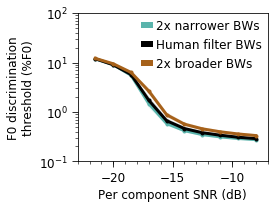

In [36]:
importlib.reload(util_figures_psychophysics)

if 'BW' in list_model_name[0]:
    color_list = ['#5ab4ac', 'k', '#a6611a'] # CMAP FOR COCH FILTER BW
else:
    color_list = ['#fdb863', '#e08214', '#b35806', 'k', '#8073ac', '#b2abd2'] #  CMAP FOR IHC LOWPASS

# color_list = np.array([[90,180,172], [0,0,0], [166,97,26]])/256 # CMAP FOR COCH FILTER BW

fig, ax = plt.subplots(figsize=(4, 3))
for cidx, (list_results_dict, model_name) in enumerate(zip(list_list_results_dict, list_model_name)):
    
    kwargs = {
        'key_xval': key_xval,
        'str_xlabel': 'Per component SNR (dB)',
        'xlimits': [-23, -7],
        'xticks': 5,
        'xticks_minor': 1,
        'include_yerr': True,
        'plot_kwargs_update': {
            'color': color_list[cidx],
            'label': model_name,
            'lw': 3,
            'marker': '.',
            'markersize': 6,
        },
        'kwargs_legend': {
            'ncol': 1,
            'handlelength': 0.5,
            'borderpad': 0,
            'columnspacing': 1,
            'loc': 'upper right',
            'handletextpad':0.5,
        },
    }
    
    util_figures_psychophysics.make_f0dl_threshold_plot(ax, list_results_dict, **kwargs)

import matplotlib
leg = [c for c in ax.get_children() if isinstance(c, matplotlib.legend.Legend)]
if len(leg) == 1:
    for legobj in leg[0].legendHandles:
        legobj.set_linewidth(6.0)

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_f0dl_vs_SNR_manipulation_cochFilterBWs.pdf')
# # save_fn = os.path.join(save_dir, 'psychophysics_f0dl_vs_SNR_manipulation_cochFilterBWs_rep10archs.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


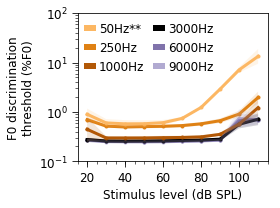

In [26]:
importlib.reload(util_figures_psychophysics)

color_list = np.array([[253,184,99], [224,130,20], [179,88,6], [0,0,0], [128,115,172], [178,171,210]])/256# CMAP FOR IHC LOWPASS

fig, ax = plt.subplots(figsize=(4, 3))
zorder = 0
for cidx, (list_results_dict, model_name) in enumerate(zip(list_list_results_dict, list_model_name)):
    
    kwargs = {
        'key_xval': key_xval,
        'str_xlabel': 'Stimulus level (dB SPL)',
        'xlimits': [15, 115],
        'xticks': 20,
        'xticks_minor': 5,
        'include_yerr': True,
        'plot_kwargs_update': {
            'color': color_list[cidx],
            'label': model_name,
            'lw': 3,
            'zorder': zorder,
            'marker': '.',
            'markersize': 6,
        },
        'kwargs_legend': {
            'ncol': 2,
            'handlelength': 0.5,
            'borderpad': 0.25,
            'columnspacing': 1,
            'loc': 'upper left',
            'handletextpad':0.5,
        },
    }
    
    util_figures_psychophysics.make_f0dl_threshold_plot(ax, list_results_dict, **kwargs)
    zorder -= 1

import matplotlib
leg = [c for c in ax.get_children() if isinstance(c, matplotlib.legend.Legend)]
if len(leg) == 1:
    for legobj in leg[0].legendHandles:
        legobj.set_linewidth(6.0)

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_f0dl_vs_dBSPL_manipulation_IHClowpass.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)
# fig.savefig('tmp.pdf', bbox_inches='tight', pad_inches=0, transparent=False)

